<h1> Actividad en Clase Transfer Learning </h1>

A01640260 | Alan Ricardo Vilchis Arceo

A01633784 | Alejandro Pizarro Chávez

A01634164 | Diego Rosas

A01639224 | Fausto Alejandro Palma Cervantes

TC3007C.502 | Inteligencia artificial avanzada para la ciencia de datos II

16 de octubre de 2023


In [1]:
# conexion con google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Importar Librerías

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##Procesamiento de datos

In [3]:
PATH = '/content/drive/Shareddrives/Penta Tech/Actividad en Clase Transfer Learning/mouse_keyboard_and_monitor_filtered'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size = IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle = True,
                                                                 batch_size= BATCH_SIZE,
                                                                 image_size = IMG_SIZE)

Found 2348 files belonging to 3 classes.
Found 619 files belonging to 3 classes.


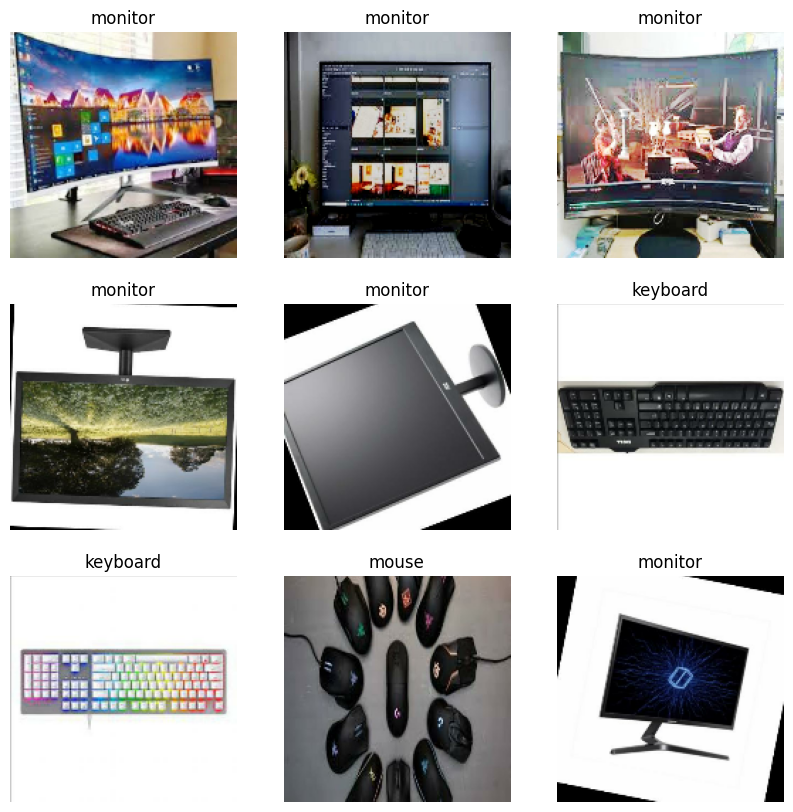

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for image, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Numero de batches para validation_dataset  = %d' %tf.data.experimental.cardinality(validation_dataset))
print('Numero de batches para test_dataset  = %d' %tf.data.experimental.cardinality(test_dataset))

Numero de batches para validation_dataset  = 16
Numero de batches para test_dataset  = 4


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

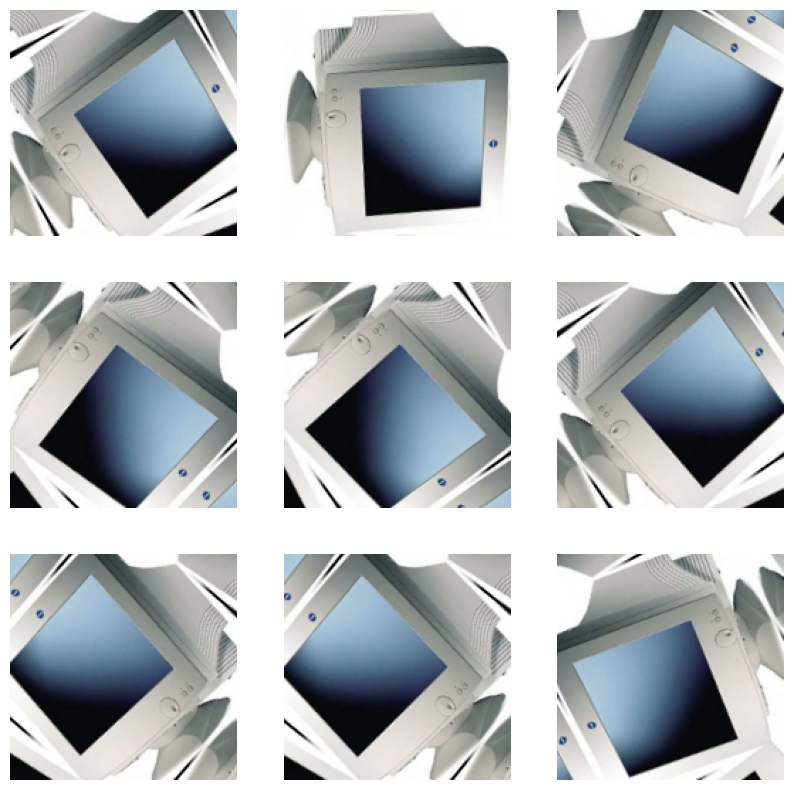

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset = -1)

preprocess_input = tf.keras.applications.mobilenet.preprocess_input

##Cargar Red ResNet50

In [10]:
IMG_SHAPE = IMG_SIZE + (3, )
print(IMG_SHAPE)

base_model = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

(160, 160, 3)


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 2048)


In [12]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [13]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 51200)


In [14]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


##Unir modelo

In [15]:
inputs = tf.keras.Input(shape = (160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy']
              )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0     

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print(loss0)
print(accuracy0)

74/74 [==============================] - 10s 99ms/step - loss: 1.0907 - accuracy: 0.4097
1.0906639099121094
0.4097103774547577


In [18]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
74/74 [==============================] - 18s 195ms/step - loss: 0.6177 - accuracy: 0.7534 - val_loss: 0.4885 - val_accuracy: 0.8118
Epoch 2/10
74/74 [==============================] - 14s 177ms/step - loss: 0.4416 - accuracy: 0.8301 - val_loss: 0.3944 - val_accuracy: 0.8463
Epoch 3/10
74/74 [==============================] - 14s 179ms/step - loss: 0.3528 - accuracy: 0.8612 - val_loss: 0.3346 - val_accuracy: 0.8744
Epoch 4/10
74/74 [==============================] - 14s 178ms/step - loss: 0.3468 - accuracy: 0.8782 - val_loss: 0.2993 - val_accuracy: 0.8952
Epoch 5/10
74/74 [==============================] - 14s 181ms/step - loss: 0.3424 - accuracy: 0.8705 - val_loss: 0.4176 - val_accuracy: 0.8458
Epoch 6/10
74/74 [==============================] - 14s 178ms/step - loss: 0.3315 - accuracy: 0.8803 - val_loss: 0.2832 - val_accuracy: 0.9003
Epoch 7/10
74/74 [==============================] - 13s 176ms/step - loss: 0.3451 - accuracy: 0.8701 - val_loss: 0.2541 - val_accuracy: 0.9093

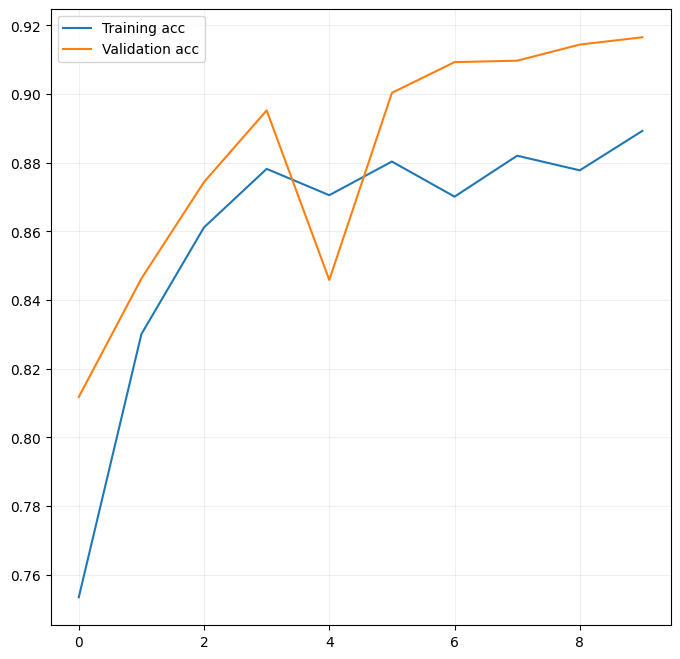

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.plot(acc, label = 'Training acc')
plt.plot(val_acc, label = 'Validation acc')

plt.legend()
plt.grid(alpha=0.2)

##Fine-Tuning

In [20]:
base_model.trainable = True

print('Numero de capas: ', len(base_model.layers))

Numero de capas:  175


In [21]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [22]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0     

In [23]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
74/74 [==============================] - 32s 222ms/step - loss: 2.2416 - accuracy: 0.5801 - val_loss: 0.6724 - val_accuracy: 0.6831
Epoch 11/20
74/74 [==============================] - 16s 206ms/step - loss: 0.6751 - accuracy: 0.7283 - val_loss: 0.3742 - val_accuracy: 0.8497
Epoch 12/20
74/74 [==============================] - 18s 228ms/step - loss: 0.4656 - accuracy: 0.8152 - val_loss: 0.3470 - val_accuracy: 0.8790
Epoch 13/20
74/74 [==============================] - 16s 210ms/step - loss: 0.3892 - accuracy: 0.8505 - val_loss: 0.7136 - val_accuracy: 0.7751
Epoch 14/20
74/74 [==============================] - 15s 202ms/step - loss: 0.3528 - accuracy: 0.8603 - val_loss: 0.2415 - val_accuracy: 0.9050
Epoch 15/20
74/74 [==============================] - 15s 200ms/step - loss: 0.3278 - accuracy: 0.8786 - val_loss: 0.2041 - val_accuracy: 0.9267
Epoch 16/20
74/74 [==============================] - 16s 203ms/step - loss: 0.3004 - accuracy: 0.8876 - val_loss: 0.4393 - val_accuracy:

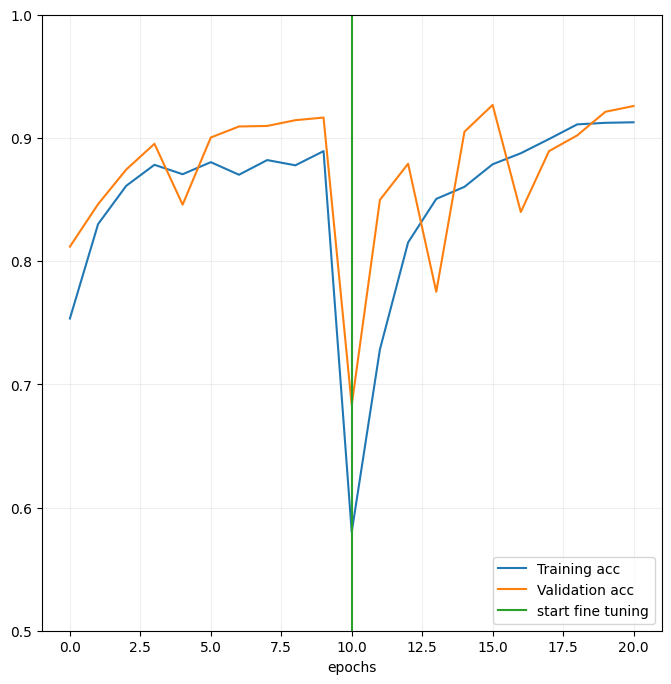

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize = (8, 8))
plt.plot(acc, label = 'Training acc')
plt.plot(val_acc, label = 'Validation acc')

plt.ylim([0.5, 1])

plt.plot([initial_epochs, initial_epochs,],
         plt.ylim(), label = 'start fine tuning')

plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.grid(alpha=0.2)

##Predicción

74/74 [==============================] - 7s 81ms/step


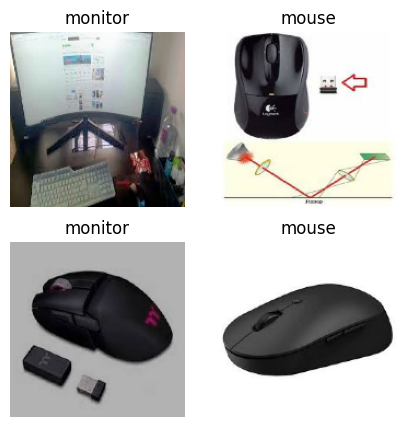

In [31]:
predictions = model.predict(test_dataset)

plt.figure(figsize=(5, 5))
for image, labels in test_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis('off')